# FuseTS - Whittaker example
This document displays the Whittaker algorithm, a component of the FuseTS library. The Whittaker algorithm is a smoothing algorithm that is designed to handle time series data. The algorithm is effective in removing noise and other fluctuations from time series data, which can be important when trying to understand trends in the data. 

## Setting up the OpenEO process
The first step includes setting up the OpenEO processing through the [OpenEO Python Client](https://open-eo.github.io/openeo-python-client/). Since the Whittaker algorithm is integrated as an [user defined process](https://open-eo.github.io/openeo-python-client/cookbook/udp_sharing.html), we can use the `datacube_from_process` function to execute the function.

In [1]:
import openeo
import json
import pandas as pd
import matplotlib.pyplot as plt
from openeo.rest.conversions import timeseries_json_to_pandas
from shapely.geometry import box

In [2]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()
service = 'whittaker'
namespace = 'u:bramjanssen'

Authenticated using refresh token.


In [3]:
connection.describe_process(service, namespace=namespace)

{'description': "# Whittaker\n\n## Description\n\nWhittaker represents a computationally efficient reconstruction method for smoothing and gap-filling of time series.\nThe main function takes as input two vectors of the same length: the y time series data (e.g. NDVI) and the\ncorresponding temporal vector (date format) x, comprised between the start and end dates of a satellite image\ncollection. Missing or null values as well as the cloud-masked values (i.e. NaN), are handled by introducing a\nvector of 0-1 weights w, with wi = 0 for missing observations and wi=1 otherwise. Following, the Whittaker smoother\nis applied to the time series profiles, computing therefore a daily smoothing interpolation.\n\nWhittaker's fast processing speed was assessed through an initial performance testing by comparing different\ntime series fitting methods. Average runtime takes 0.0107 seconds to process a single NDVI temporal profile.\n\nThe smoother performance can be adjusted by tuning the lambda parameter, which penalizes the time series roughness:\nthe larger lambda the smoother the time series at the cost of the fit to the data getting worse. We found a lambda of\n10000 adequate for obtaining more convenient results. A more detailed description of the algorithm can be\nfound in the original work of Eilers 2003.\n\n\n\n",
 'id': 'whittaker',
 'parameters': [{'description': 'A data cube.',
   'name': 'data',
   'schema': {'subtype': 'raster-cube', 'type': 'object'}},
  {'default': 10000,
   'description': 'Lambda parameter to change the Whittaker smoothing',
   'name': 'smoothing_lambda',
   'optional': True,
   'schema': {'type': 'number'}}],
 'summary': 'Execute a computationally efficient reconstruction method for smoothing and gap-filling of time series.'}

In [29]:
spat_ext = {
          "type": "Polygon",
          "coordinates": [
            [
              [
                5.170012098271149,
                51.25062964728295
              ],
              [
                5.17085904378298,
                51.24882567194015
              ],
              [
                5.17857421368097,
                51.2468515482926
              ],
              [
                5.178972704726344,
                51.24982704376254
              ],
              [
                5.170012098271149,
                51.25062964728295
              ]
            ]
          ]
        }
temp_ext = ["2022-01-01","2022-12-31"]


One of the parameters in Whittaker services is known as Lambda. This parameter affects the level of smoothing performed by the service. A larger value of Lambda results in a smoother time series, but at the expense of a poorer fit to the data.

In [30]:
smoothing_lambda = 10000

To begin, we calculate the base NDVI data cube. In the subsequent steps, we utilize this data cube to implement Whittaker smoothing. Finally, we compute time series for both the base NDVI and the smoothed version.

In [36]:
base = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["B04","B08","SCL"])
base_cloudmasked = base.process("mask_scl_dilation", data=base, scl_band_name="SCL")
base_ndvi = base_cloudmasked.ndvi(red="B04", nir="B08")

In [37]:
whittaker = connection.datacube_from_process(service, namespace=f'https://openeo.vito.be/openeo/1.1/processes/{namespace}/{service}', data=base_ndvi, smoothing_lambda=smoothing_lambda)

/Users/bram/VITO/FuseTS/venv_py10/lib/python3.10/site-packages/openeo/metadata.py:255: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


In [38]:
base_ndvi = base_ndvi.aggregate_spatial(spat_ext, reducer='mean')
whittaker = whittaker.aggregate_spatial(spat_ext, reducer='mean')

In [39]:
whittaker_job = whittaker.execute_batch(out_format="json", title=f'AI4FOOD - Whittaker', job_options={
    'udf-dependency-archives': [
         'https://artifactory.vgt.vito.be:443/auxdata-public/ai4food/fusets_venv.zip#tmp/venv',
        'https://artifactory.vgt.vito.be:443/auxdata-public/ai4food/fusets.zip#tmp/venv_static'
    ]
})
whittaker_job.get_results().download_file('./whittaker.json')

0:00:00 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': send 'start'
0:00:18 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': queued (progress N/A)
0:00:23 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': queued (progress N/A)
0:00:29 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': queued (progress N/A)
0:00:37 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': queued (progress N/A)
0:00:47 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': queued (progress N/A)
0:01:00 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': queued (progress N/A)
0:01:15 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': queued (progress N/A)
0:01:34 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': queued (progress N/A)
0:01:58 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': queued (progress N/A)
0:02:28 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': running (progress N/A)
0:03:13 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': running (progress N/A)
0:03:59 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': running (progress N/A)
0:04:58 Job 'j-3e6c5aa9d3764ce7ac35b9d67944016d': running (progress N/

PosixPath('whittaker.json')

In [40]:
base_ndvi.download('./base.json', format='json')

## Comparing the results
Having obtained both the base NDVI and the smoothed version, we can now proceed to compare the outcomes.

In [43]:
cubes_dfs = []
cols = ['Raw NDVI', 'Whittaker NDVI']
for result in ['base.json', 'whittaker.json']:
    with open(result, 'r') as result_file:
        df = timeseries_json_to_pandas(json.load(result_file))
        df.index = pd.to_datetime(df.index)
        cubes_dfs.append(df)    
        result_file.close()
joined_df = pd.concat(cubes_dfs, axis=1)
joined_df = joined_df.rename(columns={0: cols[0], 1: cols[1]})
joined_df

,Raw NDVI,Whittaker NDVI
date,,
2022-02-24 00:00:00+00:00,0.728168,0.723309
2022-03-03 00:00:00+00:00,0.706112,0.680744
2022-03-06 00:00:00+00:00,0.656712,0.662565
2022-03-08 00:00:00+00:00,0.650107,0.650508
2022-03-18 00:00:00+00:00,0.591761,0.591768
2022-03-21 00:00:00+00:00,0.540323,0.574894
2022-03-23 00:00:00+00:00,0.548298,0.563897
2022-03-26 00:00:00+00:00,0.539811,0.547767
2022-03-28 00:00:00+00:00,0.513666,0.537229


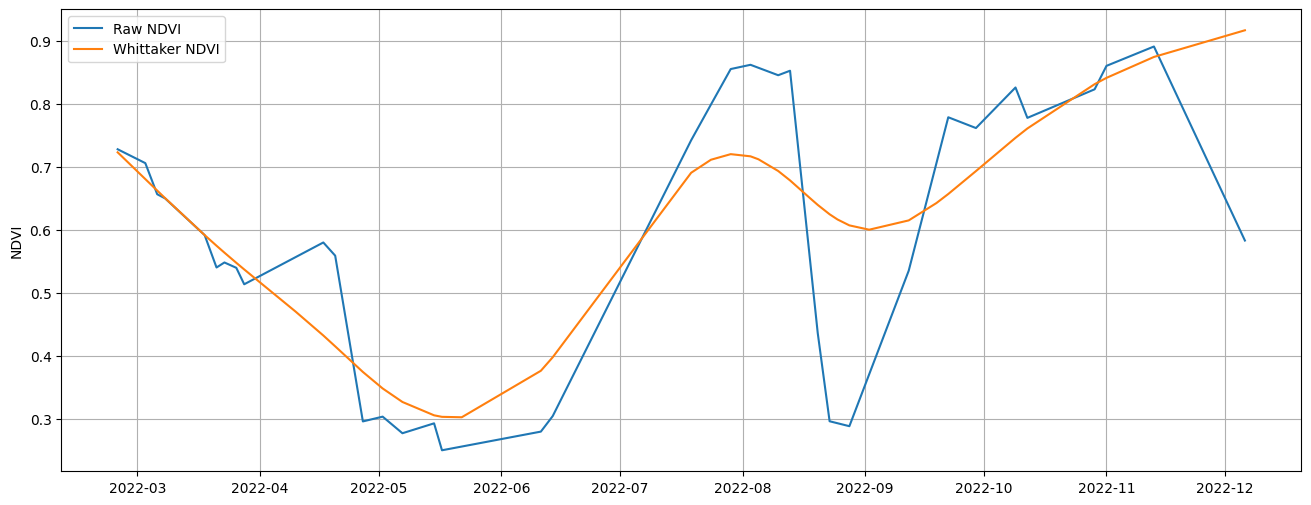

In [50]:
plt.figure(figsize= (16,6))
for col in cols:
    values = joined_df[~joined_df[col].isna()]
    plt.plot(values.index, values[col], '-', label=col)
plt.ylabel ('NDVI')
plt.grid(True)
plt.legend()